# Machine Learning phases of matter

## Abstract
This project aims to reobtain the results presented in [Machine learning phases of matter (Juan Carrasquilla, Roger G. Melko)](https://arxiv.org/abs/1605.01735) regarding the two-dimensional square Ising model. The authors show that a standard _feed-forward neural network_ (FFNN) is a suitable tool to detect Ising's model phase transition.  
This is done by first comparing the behavior of a _fully connected neural networr_ (FCNN) to a hand-made Toy model.  
Then the number of parameters of the FCNN is increased and the accuracy of the model is studied as a function of the lattice size to remove boundary effects.   In the original article, the FCNN is then upgraded to a _convolutional neural network_ to test its accuracy on non-Ising Hamiltonians.  
Finally, as an appendix, the original data is analyzed with the _t-stochastic neighbors embedding_ algorithm to separate the data into clusters.

The full project can be found on GitHub: [https://github.com/NerusSkyhigh/Machine-Learning-Phases-of-Matter](https://github.com/NerusSkyhigh/Machine-Learning-Phases-of-Matter).

---

In this first notebook, the Monte Carlo code written is tested to ensure correct sampling. In particular, the magnetization checks whether the phase transition is correctly reproduced by the model while the autocorrelation is used to esteem the minimum number of thermalisation steps between different samples.

In [1]:
!rm -rf sample_data Machine-Learning-Phases-of-Matter MonteCarloSampling data.csv
!git clone https://github.com/NerusSkyhigh/Machine-Learning-Phases-of-Matter

# Compile C source codes
!gcc -Wall Machine-Learning-Phases-of-Matter/MonteCarloSampling.c -o MonteCarloSampling.o -lm

Cloning into 'Machine-Learning-Phases-of-Matter'...
remote: Enumerating objects: 204, done.
remote: Counting objects: 100% (204/204), done.
remote: Compressing objects: 100% (148/148), done.
remote: Total 204 (delta 93), reused 157 (delta 51), pack-reused 0
Receiving objects: 100% (204/204), 8.74 MiB | 16.77 MiB/s, done.
Resolving deltas: 100% (93/93), done.


In [2]:
#@markdown Load libraries and helper functions
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# CONSTANTS
critical_temperature = 2/( np.log( np.sqrt(2)+1) )

# FUNCTIONS
def generate_data(lowest_temperature, increment_temperature, highest_temperature,
                  lattice_side, number_of_configurations, number_of_thermalisation_steps,
                  filename='data.csv', clear_old_data=True, show_termalisation_info=False):

  debug_flag = "" if show_termalisation_info else "1>/dev/null"
  clear_flag = f"rm -rf {filename}" if clear_old_data else ""

  sh = f"""
  set -e
  export LC_NUMERIC="en_US.UTF-8"

  {clear_flag}

  for T in $(seq {lowest_temperature} {increment_temperature} {highest_temperature})
  do
    ./MonteCarloSampling.o --lattice-side {lattice_side} \
                          --temperature $T \
                          --number-of-configurations {number_of_configurations} \
                          --thermalisation-steps {number_of_thermalisation_steps} \
                          --output-file '{filename}' {debug_flag}
  done
  """
  with open('script.sh', 'w') as file:
    file.write(sh)

  !bash script.sh && rm script.sh


def dataframe_from_lattice_csv(fileName, lattice_side):
    df = pd.read_csv(fileName, names=['L', 'T', 'E']+['LP'+str(i) for i in range(lattice_side*lattice_side)] )

    df['lattice'] = df[df.columns[3:]].apply( lambda x: np.array(x), axis=1)
    df = df.drop(columns=['L']+['LP'+str(i) for i in range(lattice_side*lattice_side)])
    df['magnetization']  = df['lattice'].apply(lambda x: x.sum()/x.shape[0])

    return df

## Notebook 01 - Monte Carlo Simulation

### Magnetization
The first check consists in the magnetization. The test will be performed with the parameters presented below. As no esteem of the decorrelation length is available yet, a dummy value is used.

In [3]:
lowest_temperature = 1 #@param {type:"number"}
highest_temperature = 3.5 #@param {type:"number"}
increment_temperature = 0.02 #@param {type:"number"}
lattice_side = 8 #@param {type:"integer"}
number_of_configurations = 250 #@param {type:"integer"}
number_of_thermalisation_steps = 1000 #@param {type:"integer"}

filename = "magnetization_data.csv"

generate_data(lowest_temperature, increment_temperature, highest_temperature,
              lattice_side, number_of_configurations, number_of_thermalisation_steps,
              filename, clear_old_data=True, show_termalisation_info=False)

print(f"Data Generation completed. The files are available in {filename}.")

Data Generation completed. The files are available in magnetization_data.csv.


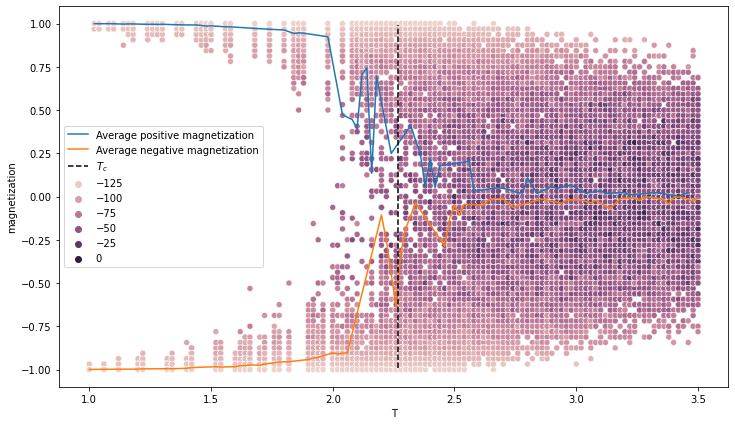

In [4]:
#@markdown Plot of the configurations with average positive and negative magnetization. Hue is linked to the energy of the configuration.
df = dataframe_from_lattice_csv('magnetization_data.csv', lattice_side)

# Compute average magnetization
T_unique_vector = np.unique(df['T'])
magnetization_at_T = np.empty( T_unique_vector.shape[0] )

for i, T_uniq in enumerate(T_unique_vector):
    mask_T_uniq = df['T'] == T_uniq
    df_magnetization_at_T_uniq = df[mask_T_uniq]['magnetization']
    magnetization_at_T[i] = df_magnetization_at_T_uniq.sum() / df_magnetization_at_T_uniq.shape[0]

positive_magnetization_mask = magnetization_at_T>0


# Plot the magnetization with the corresponding energy and critical temperature
fig, ax = plt.subplots(figsize=(12,7))
sns.scatterplot(x=df['T'], y=df['magnetization'],
                hue=df['E'], ax=ax)

sns.lineplot(x=T_unique_vector[positive_magnetization_mask],
             y=magnetization_at_T[positive_magnetization_mask],
             label="Average positive magnetization", ax=ax)
sns.lineplot(x=T_unique_vector[~positive_magnetization_mask],
             y=magnetization_at_T[~positive_magnetization_mask],
             label="Average negative magnetization", ax=ax)

plt.axvline(critical_temperature, 0.05, 0.95, label=r"$T_c$",
            color="k", linestyle='dashed');
plt.legend()
plt.show();

The magnetization is correctly reproduced: below the critical point two distinct states are present, one with positive magnetization and one with negative magnetization. After the critical temperature $T_c$ is reached the two states merge into one.  
The two lines show (respectively) the average positive and negative magnetization. It is possible to notice that they are well separated for $T<T_c$ but tend to merge for higher temperatures.  
The hue of the points represents the energy of the configuration as units of the interaction strength $J$.

### Autocorrelation
The configuration used as training data will be generated using a Monte Carlo sampling on a $L \times L$ squared lattice. An important property that the training data must satisfy in this case is *independence*. This can be assured by generating and discarding $N$ configurations between the ones saved. The number $N$ is somewhat arbitrary, but a good esteem can be obtained by analyzing the correlation between samples. In this particular project the measure used is the **autocorrelation**:

$$ \chi (t) = \frac{\langle x_0 x_t\rangle - \langle x\rangle^2}{\langle x^2\rangle - \langle x\rangle^2}$$

which quantifies the amount of correlation between a configuration at time $t_0$ and at time $t_0 + t$.
It's important to notice that:
1. The number of samples available is finite therefore the correlation for small $t$ is esteemed better than for the higher value of $t$;
2. The mean and the variance are assumed to be time-invariant.

This estimator should have an exponential behavior starting from 1 and decreasing to zero as t goes to infinity.

> Note: the program assumes a *cold initialization*, that is the initial configuration has all spins set either to +1 or all to -1. The analysis of the correlation will discard the first 10000 configurations point hoping that at that point the system will be thermalized.

In [5]:
lowest_temperature = 2 #@param {type:"number"}
highest_temperature = 3.5 #@param {type:"number"}
increment_temperature = 0.2 #@param {type:"number"}
lattice_side = 30 #@param {type:"integer"}
number_of_configurations = 20000 #@param {type:"integer"}
number_of_thermalisation_steps = 0 #@param {type:"integer"}
show_termalisation_info = False #@ param {type:"boolean"}
clear_old_data = True #@ param {type:"boolean"}

filename = "autocorrelation_data.csv"

generate_data(lowest_temperature, increment_temperature, highest_temperature,
              lattice_side, number_of_configurations, number_of_thermalisation_steps,
              filename, clear_old_data, show_termalisation_info)
print(f"Data Generation completed. The files are available in {filename}.")

Data Generation completed. The files are available in autocorrelation_data.csv.


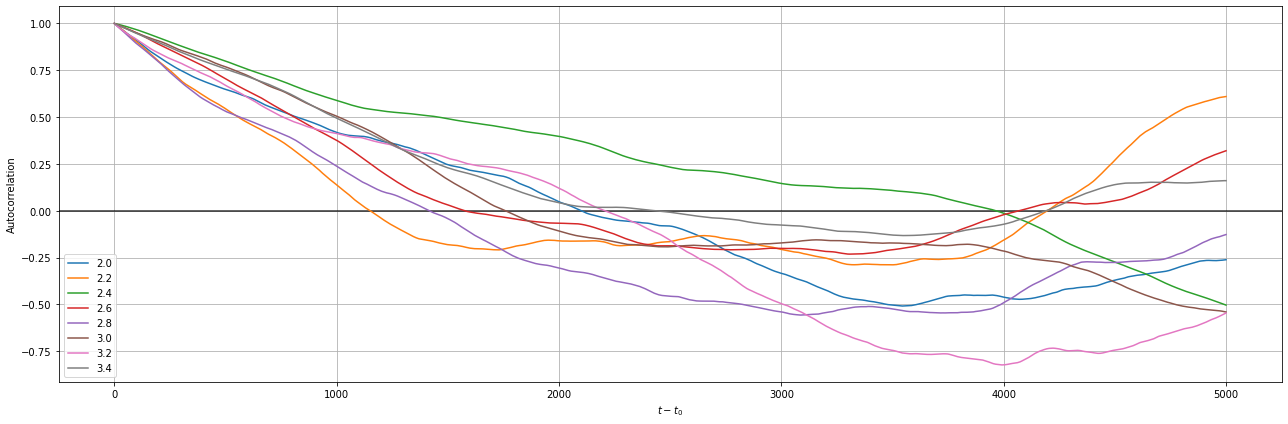

In [6]:
#@markdown Plot of the autocorrelation as a function of the distance $t-t_0$.
import numpy as np
import matplotlib.pyplot as plt

df = dataframe_from_lattice_csv('autocorrelation_data.csv', lattice_side)

def autocorrelation(x):
  x = x-np.mean(x)
  N = x.shape[0]
  autocorrelation = np.empty(N)
  for i in range(N):
    autocorrelation[i] = np.dot(x[:N-i], x[i:])/(N-i)

  return autocorrelation/autocorrelation[0]


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 6)) 
ax.axhline(y=0, color='k', alpha=0.8)

for T_uniq in np.unique(df['T']):
    # Skip the first 10000 configurations, hope they are enough to thermalize
    autocorr = autocorrelation(df[df['T']==T_uniq]['magnetization'][10000:])

    t_max = int(autocorr.shape[0]/2) # I want a good esteem even for high t-t0
    time = np.arange(1, t_max+1)
    ax.plot(time, autocorr[:t_max], label=T_uniq)

ax.set_xlabel(r"$t-t_0$")
ax.grid()
ax.legend()

ax.set_ylabel("Autocorrelation")
plt.tight_layout()
plt.show();

  The two plots show the autocorrelation as a function of the time step both in linear and logarithmics scale. The autocorrelation behaves as expected: it starts from one and decreases exponentially with a decaying constant dependend on the temperature. $number\_of\_thermalisation\_steps$ will be set to $1000$.